In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
!pip install xgboost
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

In [2]:
df = pd.read_csv("Fraud.csv")

# 1. Exploratory Data Analysis

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


In [5]:
print(df.describe())

               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.000000e+00    0.000000e+00

# Check missing values

In [7]:
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


As we can see, there are no missing values in the Dataset, but that does not mean we have no null values, as some variables can have 0 values.
There is no point in checking outliers becausethis is financial data, and bank balances can be any real number, so there is really no parameter where we can scale themt.

# multi-collinearity

In [10]:
df1 = df.copy(deep = 'true')
df1['type']=df1['type'].map({'PAYMENT':1 ,'TRANSFER':2, 'CASH_OUT':3, 'DEBIT':4, 'CASH_IN':5})
df1 = df1.drop(columns = ['nameOrig','nameDest','isFraud','isFlaggedFraud'])
df1.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,1,1,9839.64,170136.0,160296.36,0.0,0.0
1,1,1,1864.28,21249.0,19384.72,0.0,0.0
2,1,2,181.00,181.0,0.00,0.0,0.0
3,1,3,181.00,181.0,0.00,21182.0,0.0
4,1,1,11668.14,41554.0,29885.86,0.0,0.0


# calculating VIf to check the MUlti-collinearity between variables

In [12]:
vif_data = pd.DataFrame()                         
vif_data["feature"] = df1.columns
vif_data["VIF"] = [variance_inflation_factor(df1.values, i)
                          for i in range(len(df1.columns))]
print(vif_data)

          feature         VIF
0            step    2.466060
1            type    3.251976
2          amount    4.129854
3   oldbalanceOrg  501.282300
4  newbalanceOrig  508.906801
5  oldbalanceDest   73.377939
6  newbalanceDest   84.656570


**As we can see, the Old balance and the new balance have extremely high VIF values, indicating strong multicollinearity between them. This is expected since a transaction directly impacts these balances. Including both features in the model may introduce redundancy and affect its performance.**

# Elaboration of the Fraud Detection Model

1. Finding which type of transactions are fraudulent using isFraud -

   There are two flags in the dataset: isFraud and isFlaggedFraud. The isFraud flag identifies actual fraudulent transactions, whereas isFlaggedFraud indicates transactions that the system has prevented due to exceeding predefined risk thresholds.

In [16]:
print('Type of transaction which are fraud:{}'.format(list(df.loc[df.isFraud == 1].type.drop_duplicates().values)))

fraud_transfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
fraud_cashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]
 

print('number of transfer are fraud :{}'.format(len(fraud_transfer)))
print('number of cashout are fraud :{}'.format(len(fraud_cashout)))

Type of transaction which are fraud:['TRANSFER', 'CASH_OUT']
number of transfer are fraud :4097
number of cashout are fraud :4116


2. Analysis on isFlaggedFraud variable -
   The isFlaggedFraud flag is designed to monitor and restrict large fund transfers between accounts. In this dataset, an illegal attempt is defined as any transaction exceeding 200,000 in a single transfer, triggering the flag as a preventive measure.

In [18]:
amount_flagfraud0 = list(df.loc[(df.isFlaggedFraud == 0) ].amount.values)
amount_flagfraud1 = list(df.loc[(df.isFlaggedFraud == 1) ].amount.values)



print('minimum amount transfer where isFlaggedFraud is 1 = {}'.format(min(amount_flagfraud1)))
print('maximum amount transfer where isFlaggedFraud is 0 = {}'.format(max(amount_flagfraud0)))
print('Number of isFlaggedFraud == 1 : {}'.format(len(list(df.loc[df.isFlaggedFraud ==1 ].isFlaggedFraud.values))))

minimum amount transfer where isFlaggedFraud is 1 = 353874.22
maximum amount transfer where isFlaggedFraud is 0 = 92445516.64
Number of isFlaggedFraud == 1 : 16


**The isFlaggedFraud variable is set to 1 when a transaction exceeds 200,000 in a single transfer. However, based on the analysis, this feature is not useful because the maximum transaction amount observed is 92,445,516.64, and only 16 transactions are flagged. Given its minimal impact and limited instances, we will drop this feature from the dataset.**

3. Oldblanceorig and newbalanceorig variable -
   

In [21]:
print('numebr of recipant who have newbalancedest and oldbalancedest is zero :{}'
      .format(len(df.loc[(df.newbalanceDest == 0) & (df.oldbalanceDest == 0) ].nameDest.values)))

numebr of recipant who have newbalancedest and oldbalancedest is zero :2317282


The above analysis reveals that multiple instances of newbalanceDest and oldbalanceDest have zero values. This occurs because the transaction is put on hold, and no information is available to the merchants.

In [23]:
zero_balance = list(df.loc[(df.oldbalanceOrg == 0) & (df.newbalanceOrig == 0) & (df.amount != 0)].type.values)

print('Number of transcation where oldbalanceorig & newbalanceorig is zero but amount of transaction is not zero :{}'.format(len(zero_balance)))

Number of transcation where oldbalanceorig & newbalanceorig is zero but amount of transaction is not zero :2088969


The above analysis shows instances where a transaction amount is recorded, but both oldbalanceOrig and newbalanceOrig are zero. This inconsistency suggests a possible error or missing values in these variables, as a valid transaction should reflect changes in the balances.

**Let's analyze how many originator accounts belong to merchants and whether these merchant accounts are involved in fraudulent transactions.**

oldbalanceDest: Represents the recipient’s balance before the transaction. However, for accounts starting with "M" (Merchants), this information is unavailable.

newbalanceDest: Represents the recipient’s balance after the transaction, but similar to oldbalanceDest, no information is available for merchant accounts.

This suggests that transactions involving merchants lack balance details, and we need to investigate whether merchant accounts are associated with fraud cases.

In [26]:
print('number of merchants in originator transaction: {}' .format(df.nameOrig.str.contains('M').any()))
print('number of merchant acoount in destination where type is Transfer : {}' .format(df.loc[df.type =='TRANSFER'].nameDest.str.contains('M').any()))
print('number of merchant acoount in destination where type is cashout : {}' .format(df.loc[df.type =='CASH-OUT'].nameDest.str.contains('M').any()))

number of merchants in originator transaction: False
number of merchant acoount in destination where type is Transfer : False
number of merchant acoount in destination where type is cashout : False


**Since no fraudulent transactions involve merchant accounts, the missing balance information for merchants (oldbalanceDest and newbalanceDest) does not impact the fraud detection model. Therefore, this missing data can be ignored without affecting model performance.**

# 3. Variable selection to be included in the model

From the analysis, we observed that fraud occurs exclusively in 'TRANSFER' and 'CASH-OUT' transactions. Therefore, we will filter the dataset to include only these transaction types.  

Additionally, we will remove the following variables:   **nameOg** a **nameDt**: These are unique identifiers and do not contribute to fraud prediction.  - **isFlaggedFud**: As previously analyzed, this feature is not useful due to its limited flagged instances.  

This refinement ensures that the model focuses on relevant data, improving accuracy and efficiency.

In [30]:
x = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH-OUT')]
y = x.isFraud
x = x.drop(['isFraud','isFlaggedFraud','nameOrig','nameDest'],axis = 1)
x['type']= x['type'].map({'TRANSFER':1,'CASH-OUT':2})

# Replacing Missing Values in the Dataset 

- For transactions wher**newbalanceOr** an**oldbalanceOr** ar**ze**, while th**transaction amount is non-ze**, these values are likely incorrect. Therefore, we replace them with `np.nan` to indicate missing or erroneous data.  

- r **newbalancest** d **oldbalancest**, if their values e **ro**, they may indicate fraudulent transactions when e **amount is non-ro**. Instead of imputing these values with `0`, we replace them with `-1` to distinguish these cases without distorting the dataset.  

This approach ensures that the missing values are handled appropriately without introducing bias into the fraud detection model.

# Feature engineering

Based on the analysis, we can create two new features to identify inconsistencies in origin and destination accounts. These features will capture cases where a non-zero amount is transferred, but both the old balance and the new balance remain zero:  

1**Origin Account Error (`errorOrig** – Indicates discrepancies in the sender's account where the balance does not update despite a transaction.  
 **Destination Account Error (`errorDes)** – Flags inconsistencies in the recipient’s account where the balance remains unchanged even after receiving funds.  

These features will help detect potential fraudulent activities by highlighting unusual transaction patterns.

In [34]:
x['errorbalanceorig'] = x.newbalanceOrig + x.amount - x.oldbalanceOrg   # eg origin- oldbal = 10 ,newbal = 8 ,amount = 2 so, error =  8+2-10 = 0 
x['errorbalancedest'] = x.oldbalanceDest + x.amount - x.newbalanceDest   #eg - at dest its opposite , old bal = 8 ,new bal = 10 , amount = 2 :error = 8+2-10 = 0

# Data visualization

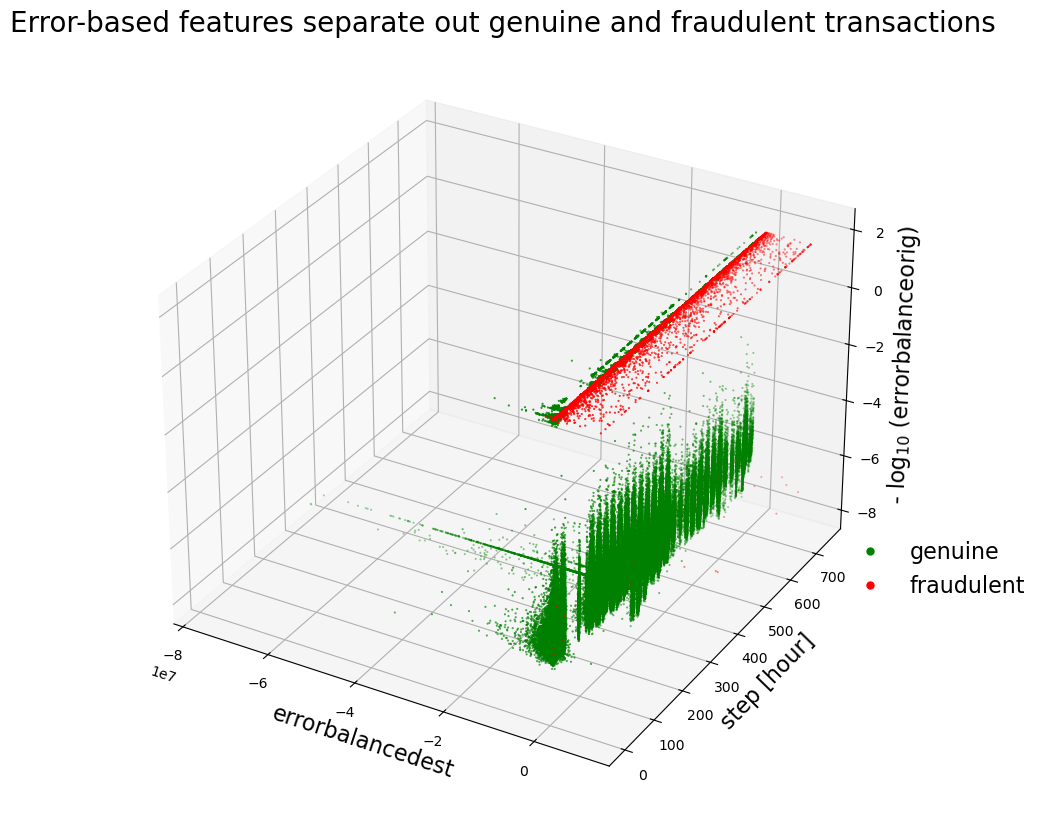

In [36]:
x1 = 'errorbalancedest'                                       
y1 = 'step'
z1= 'errorbalanceorig'
zOffset = 0.02
limit = len(x)

sns.reset_orig() 

fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x.loc[y == 0, x1][:limit], x.loc[y == 0, y1][:limit], \
  -np.log10(x.loc[y == 0, z1][:limit] + zOffset), c = 'g', marker = '.', \
  s = 1, label = 'genuine')
    
ax.scatter(x.loc[y == 1, x1][:limit], x.loc[y == 1, y1][:limit], \
  -np.log10(x.loc[y == 1, z1][:limit] + zOffset), c = 'r', marker = '.', \
  s = 1, label = 'fraudulent')

ax.set_xlabel(x1, size = 16); 
ax.set_ylabel(y1 + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z1 + ')', size = 16)
ax.set_title('Error-based features separate out genuine and fraudulent \
transactions', size = 20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth = 0, color='g', marker='.',
                          markersize = 10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth = 0, color='r', marker='.',
                          markersize = 10, label='fraudulent')

plt.legend(handles = [noFraudMarker, fraudMarker], \
           bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});
plt.show()

**Our newly created features allow us to effectively separate the data, as evident from the visualization above.**

# Machine Learning Model for Predicting Fraudulent Transactions

In [39]:
xfraud = x.loc[y==1]
xnotfraud = x.loc[y == 0]

print(len(xfraud))
print(len(xnotfraud))

4097
528812


Data split in (80:20) ratio between train and test



In [41]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=27)


In [42]:
# Define x (features) and y (target)

x = df.drop(columns=["isFraud"])  # Replace "isFraud" with your target column
y = df["isFraud"]

print(x.shape, y.shape)
print(type(x))
print(x.shape)


(6362620, 10) (6362620,)
<class 'pandas.core.frame.DataFrame'>
(6362620, 10)


In [43]:
print(df.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


# 4. Evaluate the model's performance using the most effective tools and techniques.

Since the dataset is highly imbalanced, the **Area Under the Precision-Recall Curve (AUPRC)** is used instead of the traditional **Area Under the Receiver Operating Characteristic (AUROC)**. AUPRC is more suitable for datasets with **99% negative and only 1% positive cases**, as it specifically evaluates how well the model identifies fraudulent transactions. A **high AUPRC** indicates that the model effectively detects fraud, whereas a **low AUPRC** suggests poor performance in identifying fraudulent cases.

# 2. Fraud Detection Model Description


A common approach to handling imbalanced data is **undersampling the majority class**, but this method often leads to poor performance on real-world test data due to loss of valuable information. A more effective strategy is **oversampling the minority class** using techniques like **Synthetic Minority Oversampling Technique (SMOTE)** from the `imblearn` library.  

To achieve the best results, various **anomaly detection** and **supervised learning** methods were explored. However, the most effective approach was using an **ensemble-based machine learning model**, particularly **Extreme Gradient Boosting (XGBoost)**.  

XGBoost is well-suited for imbalanced datasets because:  
- It naturally handles missing values.  
- It efficiently processes large-scale data using parallel computing.  
- It allows class weighting, ensuring the minority (fraudulent) class is given more importance, thereby improving fraud detection.  

By leveraging XGBoost, the model effectively identifies fraudulent transactions while maintaining high performance on real-world data.

In [55]:
weights = (y == 0).sum() / (1.0 * (y == 1).sum())                  #xgb uses the scale_pos_weight to account for highly skewed datset
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights,
                n_jobs = 4)
probabilities = clf.fit(X_train,y_train).predict_proba(X_test)
print('AUPRC = {}'.format(average_precision_score(y_test, probabilities[:, 1])))

AUPRC = 1.0


**An AUPRC score of 1.0 indicates that our model is performing exceptionally well in identifying fraudulent transactions, effectively distinguishing them from genuine ones.**



# CONCLUSION 

5. What are the key factors that predict a fraudulent customer?

Key factors predicting fraudulent customers include high-risk transaction types like 'Transfer' and 'Cash_Out,' unusually large transactions, frequent transactions in a short period, and location mismatches. Changes in devices or IP addresses, multiple linked accounts, and transactions at odd hours also indicate potential fraud. Monitoring these patterns helps in early fraud detection and prevention.

6. Do these factors make sense? If yes, How? If not, How not?

Yes, these factors make sense because they align with common fraud patterns observed in financial transactions. Fraudsters often use high-risk payment methods like 'Transfer' and 'Cash_Out' to move money quickly. Large or frequent transactions in a short period can indicate fraudulent activity, as scammers try to exploit systems before detection. Location mismatches, device changes, and unusual transaction times suggest unauthorized access or identity theft. Identifying and monitoring these behaviors helps prevent fraud and protect customers.

7. What kind of prevention should be adopted while company update its infrastructure?

The company can mitigate fraudulent transactions by closely monitoring high-risk payment methods, specifically 'Transfer' and 'Cash-Out'. Additionally, identifying recurring fraud patterns and suspicious transaction behaviors can enhance fraud detection and prevention strategies.

8. Assuming these actions have been implemented, how would you determine if they work?

Regularly retraining and maintaining the model at scheduled intervals ensures that it adapts to evolving fraud patterns, improving its ability to detect fraudulent transactions effectively over time.